In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
# Install required packages if not already installed
# !pip install transformers datasets torch arabert

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import pandas as pd
import re
from tqdm import tqdm

# 1. Preprocessing Function
def data_cleaner(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^؀-ۿa-zA-Z0-9\s]", "", text)  # Keep Arabic letters, English letters, and numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# 2. Load and preprocess your dataset
#df = pd.read_csv("your_dataset.csv")  # replace with your file
df = pd.read_excel('combined_dataset.xlsx')
df['text'] = df['text'].apply(data_cleaner)

# 3. Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)


# 4. Load Tokenizer and Model
model_name = "asafaya/bert-base-arabic"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 5. Tokenization
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

# 6. Dataset Class
class DepressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = DepressionDataset(train_encodings, list(train_labels))
val_dataset = DepressionDataset(val_encodings, list(val_labels))

# 7. Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# 8. Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir="./logs",
    logging_steps=10,
    do_eval=True,
    save_total_limit=2
)


# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# 10. Train the Model
trainer.train()


FileNotFoundError: [Errno 2] No such file or directory: 'combined_dataset.xlsx'

In [ ]:
# Extract texts and labels
texts = df['text'].tolist()
labels = df['label'].tolist()

# Split into train and test sets
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Tokenize test data
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128
)

# Create dataset
test_dataset = DepressionDataset(test_encodings, test_labels)

# Create DataLoader
from torch.utils.data import DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=16)


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [ ]:
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

model.eval()
all_preds = []
all_labels = []

for batch in test_dataloader:
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9667
Precision: 0.9667
Recall: 0.9667
F1-score: 0.9667


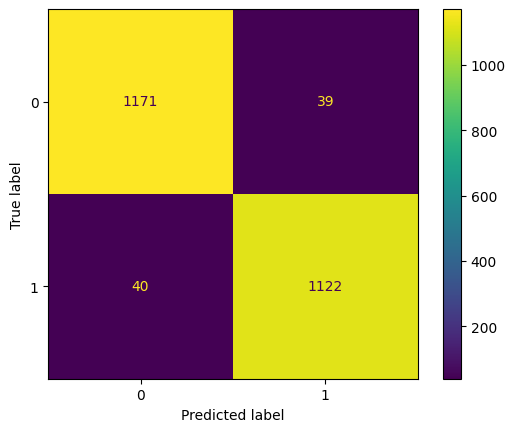

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [ ]:
model.save_pretrained("arabic_depression_model")
tokenizer.save_pretrained("arabic_depression_model")


('arabic_depression_model/tokenizer_config.json',
 'arabic_depression_model/special_tokens_map.json',
 'arabic_depression_model/vocab.txt',
 'arabic_depression_model/added_tokens.json',
 'arabic_depression_model/tokenizer.json')

In [ ]:
# Input field for user
user_input = input(":اكتب النص الذي تريد تصنيفه  ")

# Predict using your trained model
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return prediction

# Call the function and print result
label = predict(user_input)

if label == 1:
    print("⚠️ تم اكتشاف علامات الاكتئاب")
else:
    print("✅ لا توجد علامات اكتئاب")


:اكتب النص الذي تريد تصنيفه  🥲انا حزين جدا لا افهم شيء


NameError: name 'tokenizer' is not defined